In [1]:
import torch
import torchtext
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from perceiver_pytorch import Perceiver
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm.notebook import tqdm
from datetime import datetime
from babi_joint import BabiDataset, pad_collate
from torch.utils.data.dataset import Dataset
from glob import glob
from perceiver_pytorch import PerceiverIObAbI
import time

In [2]:
# UT pondernet 1470003

model = PerceiverIObAbI(
    num_tokens=179,
    context_max_seq_len=70*13,
    question_max_seq_len=13,
    dim = 16,                    # dimension of sequence to be encoded
    queries_dim = 179,            # dimension of decoder queries
#     logits_dim = 50,            # dimension of final logits
    depth = 3,                   # depth of net
    num_latents = 13,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 16,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 8,            # number of heads for latent self attention, 8
    cross_dim_head = 32,         # number of dimensions per cross attention head
    latent_dim_head = 32,        # number of dimensions per latent self attention head
    weight_tie_layers = True,   # whether to weight tie layers (optional, as indicated in the diagram)
    self_per_cross_attn = 1,     # number of self attention blocks per cross attention
    learn_latents=False
)

model_name = 'perceiverIO_bAbi'
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

66204


In [3]:
batch_size=128
max_epochs = 150

babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
                           vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
vocab_size = len(babi_dataset.QA.VOCAB)
print('len(babi_dataset) train', len(babi_dataset))
print('vocab_size', vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_loss_min = float('inf')

writer = SummaryWriter()
if not os.path.isdir(f'checkpoints/{model_name}'):
    os.mkdir(f'checkpoints/{model_name}')
now = datetime.now().strftime("%d_%m_%Y__%H_%M_%S")

for epoch in range(max_epochs):
    train_loss = 0.0
    val_loss = 0.0
    loss_sum = 0
    loss_count = 0
    model.train()
    babi_dataset.set_mode('train')
    train_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate
    )
    
    for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")):
        optimizer.zero_grad()

        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)
        
        logits = torch.squeeze(model(contexts, questions))
        loss = criterion(logits, answers)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        writer.add_scalars("losses_step", {"train_loss": loss.item() / contexts.size(0)}, epoch * len(train_loader) + batch_idx)
    
    train_loss = train_loss / len(train_loader.dataset)
    writer.add_scalars("losses_epoch", {"train_loss": train_loss}, epoch)
    train_loader_len = len(train_loader)
    
    model.eval()
    babi_dataset.set_mode('valid')
    val_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
    )
    
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
        
            contexts, questions, answers, tasks = data
            contexts = contexts.long().to(device)
            questions = questions.long().to(device)
            answers = answers.to(device)
        
            logits = torch.squeeze(model(contexts, questions))
            loss = criterion(logits, answers)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader.dataset)
    writer.add_scalars("losses_step", {"val_loss": val_loss}, (epoch + 1) * train_loader_len - 1)    
    writer.add_scalars("losses_epoch", {"val_loss": val_loss}, epoch)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
    ))
    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'checkpoints/{model_name}/checkpoint_{now}.pt')
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(checkpoint, f'checkpoints/{model_name}/best_checkpoint_{now}.pt')
        val_loss_min = val_loss

len(babi_dataset) train 180000
vocab_size 179
cuda:0


Epoch 1/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2.807991 	Validation Loss: 1.771179
Validation loss decreased (inf --> 1.771179).  Saving model ...


Epoch 2/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.548015 	Validation Loss: 1.431662
Validation loss decreased (1.771179 --> 1.431662).  Saving model ...


Epoch 3/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.355313 	Validation Loss: 1.305537
Validation loss decreased (1.431662 --> 1.305537).  Saving model ...


Epoch 4/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.265075 	Validation Loss: 1.218490
Validation loss decreased (1.305537 --> 1.218490).  Saving model ...


Epoch 5/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.186951 	Validation Loss: 1.153336
Validation loss decreased (1.218490 --> 1.153336).  Saving model ...


Epoch 6/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.135914 	Validation Loss: 1.114062
Validation loss decreased (1.153336 --> 1.114062).  Saving model ...


Epoch 7/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.103754 	Validation Loss: 1.092337
Validation loss decreased (1.114062 --> 1.092337).  Saving model ...


Epoch 8/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.076790 	Validation Loss: 1.066238
Validation loss decreased (1.092337 --> 1.066238).  Saving model ...


Epoch 9/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.057482 	Validation Loss: 1.055787
Validation loss decreased (1.066238 --> 1.055787).  Saving model ...


Epoch 10/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.041903 	Validation Loss: 1.032709
Validation loss decreased (1.055787 --> 1.032709).  Saving model ...


Epoch 11/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 1.026474 	Validation Loss: 1.017946
Validation loss decreased (1.032709 --> 1.017946).  Saving model ...


Epoch 12/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 1.008696 	Validation Loss: 1.001306
Validation loss decreased (1.017946 --> 1.001306).  Saving model ...


Epoch 13/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.991990 	Validation Loss: 0.988158
Validation loss decreased (1.001306 --> 0.988158).  Saving model ...


Epoch 14/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.976070 	Validation Loss: 0.977057
Validation loss decreased (0.988158 --> 0.977057).  Saving model ...


Epoch 15/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.960771 	Validation Loss: 0.959187
Validation loss decreased (0.977057 --> 0.959187).  Saving model ...


Epoch 16/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.946822 	Validation Loss: 0.947709
Validation loss decreased (0.959187 --> 0.947709).  Saving model ...


Epoch 17/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.935544 	Validation Loss: 0.935487
Validation loss decreased (0.947709 --> 0.935487).  Saving model ...


Epoch 18/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.926233 	Validation Loss: 0.922777
Validation loss decreased (0.935487 --> 0.922777).  Saving model ...


Epoch 19/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.918027 	Validation Loss: 0.919378
Validation loss decreased (0.922777 --> 0.919378).  Saving model ...


Epoch 20/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.909713 	Validation Loss: 0.919072
Validation loss decreased (0.919378 --> 0.919072).  Saving model ...


Epoch 21/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.901158 	Validation Loss: 0.906459
Validation loss decreased (0.919072 --> 0.906459).  Saving model ...


Epoch 22/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.894405 	Validation Loss: 0.909827


Epoch 23/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.886587 	Validation Loss: 0.896111
Validation loss decreased (0.906459 --> 0.896111).  Saving model ...


Epoch 24/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.879995 	Validation Loss: 0.882758
Validation loss decreased (0.896111 --> 0.882758).  Saving model ...


Epoch 25/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.873121 	Validation Loss: 0.880279
Validation loss decreased (0.882758 --> 0.880279).  Saving model ...


Epoch 26/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.867443 	Validation Loss: 0.873113
Validation loss decreased (0.880279 --> 0.873113).  Saving model ...


Epoch 27/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.861335 	Validation Loss: 0.883066


Epoch 28/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.856008 	Validation Loss: 0.864694
Validation loss decreased (0.873113 --> 0.864694).  Saving model ...


Epoch 29/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.850944 	Validation Loss: 0.863875
Validation loss decreased (0.864694 --> 0.863875).  Saving model ...


Epoch 30/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.847389 	Validation Loss: 0.859565
Validation loss decreased (0.863875 --> 0.859565).  Saving model ...


Epoch 31/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.844057 	Validation Loss: 0.855882
Validation loss decreased (0.859565 --> 0.855882).  Saving model ...


Epoch 32/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.839189 	Validation Loss: 0.852502
Validation loss decreased (0.855882 --> 0.852502).  Saving model ...


Epoch 33/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.836259 	Validation Loss: 0.848338
Validation loss decreased (0.852502 --> 0.848338).  Saving model ...


Epoch 34/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.832381 	Validation Loss: 0.846781
Validation loss decreased (0.848338 --> 0.846781).  Saving model ...


Epoch 35/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.829127 	Validation Loss: 0.845283
Validation loss decreased (0.846781 --> 0.845283).  Saving model ...


Epoch 36/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.826702 	Validation Loss: 0.845360


Epoch 37/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.823263 	Validation Loss: 0.842772
Validation loss decreased (0.845283 --> 0.842772).  Saving model ...


Epoch 38/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.819938 	Validation Loss: 0.839585
Validation loss decreased (0.842772 --> 0.839585).  Saving model ...


Epoch 39/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.817065 	Validation Loss: 0.828798
Validation loss decreased (0.839585 --> 0.828798).  Saving model ...


Epoch 40/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.815460 	Validation Loss: 0.828307
Validation loss decreased (0.828798 --> 0.828307).  Saving model ...


Epoch 41/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.812449 	Validation Loss: 0.830385


Epoch 42/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.809248 	Validation Loss: 0.829640


Epoch 43/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.807181 	Validation Loss: 0.819859
Validation loss decreased (0.828307 --> 0.819859).  Saving model ...


Epoch 44/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.805387 	Validation Loss: 0.818369
Validation loss decreased (0.819859 --> 0.818369).  Saving model ...


Epoch 45/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.803312 	Validation Loss: 0.817385
Validation loss decreased (0.818369 --> 0.817385).  Saving model ...


Epoch 46/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.801020 	Validation Loss: 0.824794


Epoch 47/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.799424 	Validation Loss: 0.821847


Epoch 48/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.797691 	Validation Loss: 0.816081
Validation loss decreased (0.817385 --> 0.816081).  Saving model ...


Epoch 49/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.796267 	Validation Loss: 0.813712
Validation loss decreased (0.816081 --> 0.813712).  Saving model ...


Epoch 50/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.794075 	Validation Loss: 0.810465
Validation loss decreased (0.813712 --> 0.810465).  Saving model ...


Epoch 51/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.792996 	Validation Loss: 0.812868


Epoch 52/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.791675 	Validation Loss: 0.814840


Epoch 53/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.789923 	Validation Loss: 0.805027
Validation loss decreased (0.810465 --> 0.805027).  Saving model ...


Epoch 54/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.788641 	Validation Loss: 0.806842


Epoch 55/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.786145 	Validation Loss: 0.807193


Epoch 56/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.785045 	Validation Loss: 0.803955
Validation loss decreased (0.805027 --> 0.803955).  Saving model ...


Epoch 57/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.783240 	Validation Loss: 0.802404
Validation loss decreased (0.803955 --> 0.802404).  Saving model ...


Epoch 58/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.782397 	Validation Loss: 0.803367


Epoch 59/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.780654 	Validation Loss: 0.806552


Epoch 60/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.779842 	Validation Loss: 0.801112
Validation loss decreased (0.802404 --> 0.801112).  Saving model ...


Epoch 61/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.778404 	Validation Loss: 0.804009


Epoch 62/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.776677 	Validation Loss: 0.798871
Validation loss decreased (0.801112 --> 0.798871).  Saving model ...


Epoch 63/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.775407 	Validation Loss: 0.800716


Epoch 64/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.774195 	Validation Loss: 0.796790
Validation loss decreased (0.798871 --> 0.796790).  Saving model ...


Epoch 65/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.772559 	Validation Loss: 0.791453
Validation loss decreased (0.796790 --> 0.791453).  Saving model ...


Epoch 66/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.771622 	Validation Loss: 0.795496


Epoch 67/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.769770 	Validation Loss: 0.796763


Epoch 68/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.768139 	Validation Loss: 0.797391


Epoch 69/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.767755 	Validation Loss: 0.794560


Epoch 70/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.767134 	Validation Loss: 0.797914


Epoch 71/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.764845 	Validation Loss: 0.786548
Validation loss decreased (0.791453 --> 0.786548).  Saving model ...


Epoch 72/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.764056 	Validation Loss: 0.790731


Epoch 73/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.762478 	Validation Loss: 0.790590


Epoch 74/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.761396 	Validation Loss: 0.788984


Epoch 75/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.760260 	Validation Loss: 0.790523


Epoch 76/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.759444 	Validation Loss: 0.794011


Epoch 77/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.758329 	Validation Loss: 0.788005


Epoch 78/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.757505 	Validation Loss: 0.796331


Epoch 79/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.756736 	Validation Loss: 0.783358
Validation loss decreased (0.786548 --> 0.783358).  Saving model ...


Epoch 80/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.755279 	Validation Loss: 0.787204


Epoch 81/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.754153 	Validation Loss: 0.786807


Epoch 82/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.753882 	Validation Loss: 0.787840


Epoch 83/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.752193 	Validation Loss: 0.786136


Epoch 84/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.751301 	Validation Loss: 0.789011


Epoch 85/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.750718 	Validation Loss: 0.782157
Validation loss decreased (0.783358 --> 0.782157).  Saving model ...


Epoch 86/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.749285 	Validation Loss: 0.785277


Epoch 87/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.748931 	Validation Loss: 0.784692


Epoch 88/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.748114 	Validation Loss: 0.788125


Epoch 89/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.747174 	Validation Loss: 0.783999


Epoch 90/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.745791 	Validation Loss: 0.782319


Epoch 91/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.744979 	Validation Loss: 0.781415
Validation loss decreased (0.782157 --> 0.781415).  Saving model ...


Epoch 92/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.744180 	Validation Loss: 0.781788


Epoch 93/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.743242 	Validation Loss: 0.783396


Epoch 94/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.741912 	Validation Loss: 0.791510


Epoch 95/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.741560 	Validation Loss: 0.782269


Epoch 96/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.740824 	Validation Loss: 0.785926


Epoch 97/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.740144 	Validation Loss: 0.788085


Epoch 98/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.738896 	Validation Loss: 0.784702


Epoch 99/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.738164 	Validation Loss: 0.783066


Epoch 100/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.738403 	Validation Loss: 0.783843


Epoch 101/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.736273 	Validation Loss: 0.784657


Epoch 102/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.735833 	Validation Loss: 0.782831


Epoch 103/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.735269 	Validation Loss: 0.783922


Epoch 104/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.734583 	Validation Loss: 0.781250
Validation loss decreased (0.781415 --> 0.781250).  Saving model ...


Epoch 105/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.733403 	Validation Loss: 0.780349
Validation loss decreased (0.781250 --> 0.780349).  Saving model ...


Epoch 106/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.733321 	Validation Loss: 0.787437


Epoch 107/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.732623 	Validation Loss: 0.782145


Epoch 108/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.731202 	Validation Loss: 0.780841


Epoch 109/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.730513 	Validation Loss: 0.780226
Validation loss decreased (0.780349 --> 0.780226).  Saving model ...


Epoch 110/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.729367 	Validation Loss: 0.783848


Epoch 111/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.728905 	Validation Loss: 0.789505


Epoch 112/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.728568 	Validation Loss: 0.777823
Validation loss decreased (0.780226 --> 0.777823).  Saving model ...


Epoch 113/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.727436 	Validation Loss: 0.780403


Epoch 114/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.726593 	Validation Loss: 0.781943


Epoch 115/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.727003 	Validation Loss: 0.782273


Epoch 116/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.725777 	Validation Loss: 0.778795


Epoch 117/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.724543 	Validation Loss: 0.779292


Epoch 118/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.724818 	Validation Loss: 0.779795


Epoch 119/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.723857 	Validation Loss: 0.783091


Epoch 120/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.722692 	Validation Loss: 0.787909


Epoch 121/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.722037 	Validation Loss: 0.778544


Epoch 122/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.721128 	Validation Loss: 0.784201


Epoch 123/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.721061 	Validation Loss: 0.782468


Epoch 124/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.719376 	Validation Loss: 0.786462


Epoch 125/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.719372 	Validation Loss: 0.784270


Epoch 126/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.718456 	Validation Loss: 0.783214


Epoch 127/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.717576 	Validation Loss: 0.786865


Epoch 128/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.717621 	Validation Loss: 0.785384


Epoch 129/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.716936 	Validation Loss: 0.781572


Epoch 130/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.716111 	Validation Loss: 0.784524


Epoch 131/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.715068 	Validation Loss: 0.789203


Epoch 132/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.714693 	Validation Loss: 0.781664


Epoch 133/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.714569 	Validation Loss: 0.783546


Epoch 134/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.714038 	Validation Loss: 0.784941


Epoch 135/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.712760 	Validation Loss: 0.786789


Epoch 136/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.712656 	Validation Loss: 0.784456


Epoch 137/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.711989 	Validation Loss: 0.792371


Epoch 138/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.710736 	Validation Loss: 0.786358


Epoch 139/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.710444 	Validation Loss: 0.785564


Epoch 140/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.709981 	Validation Loss: 0.782237


Epoch 141/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.709319 	Validation Loss: 0.786542


Epoch 142/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.708410 	Validation Loss: 0.781501


Epoch 143/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.709404 	Validation Loss: 0.785704


Epoch 144/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.706539 	Validation Loss: 0.786602


Epoch 145/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.707573 	Validation Loss: 0.790957


Epoch 146/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.706397 	Validation Loss: 0.787483


Epoch 147/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.706203 	Validation Loss: 0.780590


Epoch 148/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.704939 	Validation Loss: 0.779451


Epoch 149/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.705773 	Validation Loss: 0.785000


Epoch 150/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.704148 	Validation Loss: 0.785366


cuda:0
len(babi_dataset) train 180000
vocab_size 179


Inference:   0%|          | 0/157 [00:00<?, ?it/s]

/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/

0.64035
                     precision    recall  f1-score   support

              apple       0.80      0.74      0.77       341
     apple,football       0.00      0.00      0.00        11
apple,football,milk       0.00      0.00      0.00         1
         apple,milk       0.00      0.00      0.00        10
           bathroom       0.63      0.63      0.63      1195
            bedroom       0.64      0.61      0.63      1437
               bill       0.62      0.55      0.59       164
              bored       1.00      1.00      1.00       159
                cat       0.60      0.53      0.56       213
             cinema       0.43      0.44      0.44       171
                e,e       0.25      0.04      0.06        81
                e,n       0.08      0.06      0.07        88
                e,s       0.00      0.00      0.00        79
           football       0.73      0.75      0.74       281
     football,apple       0.25      0.06      0.09        18
football,apple,

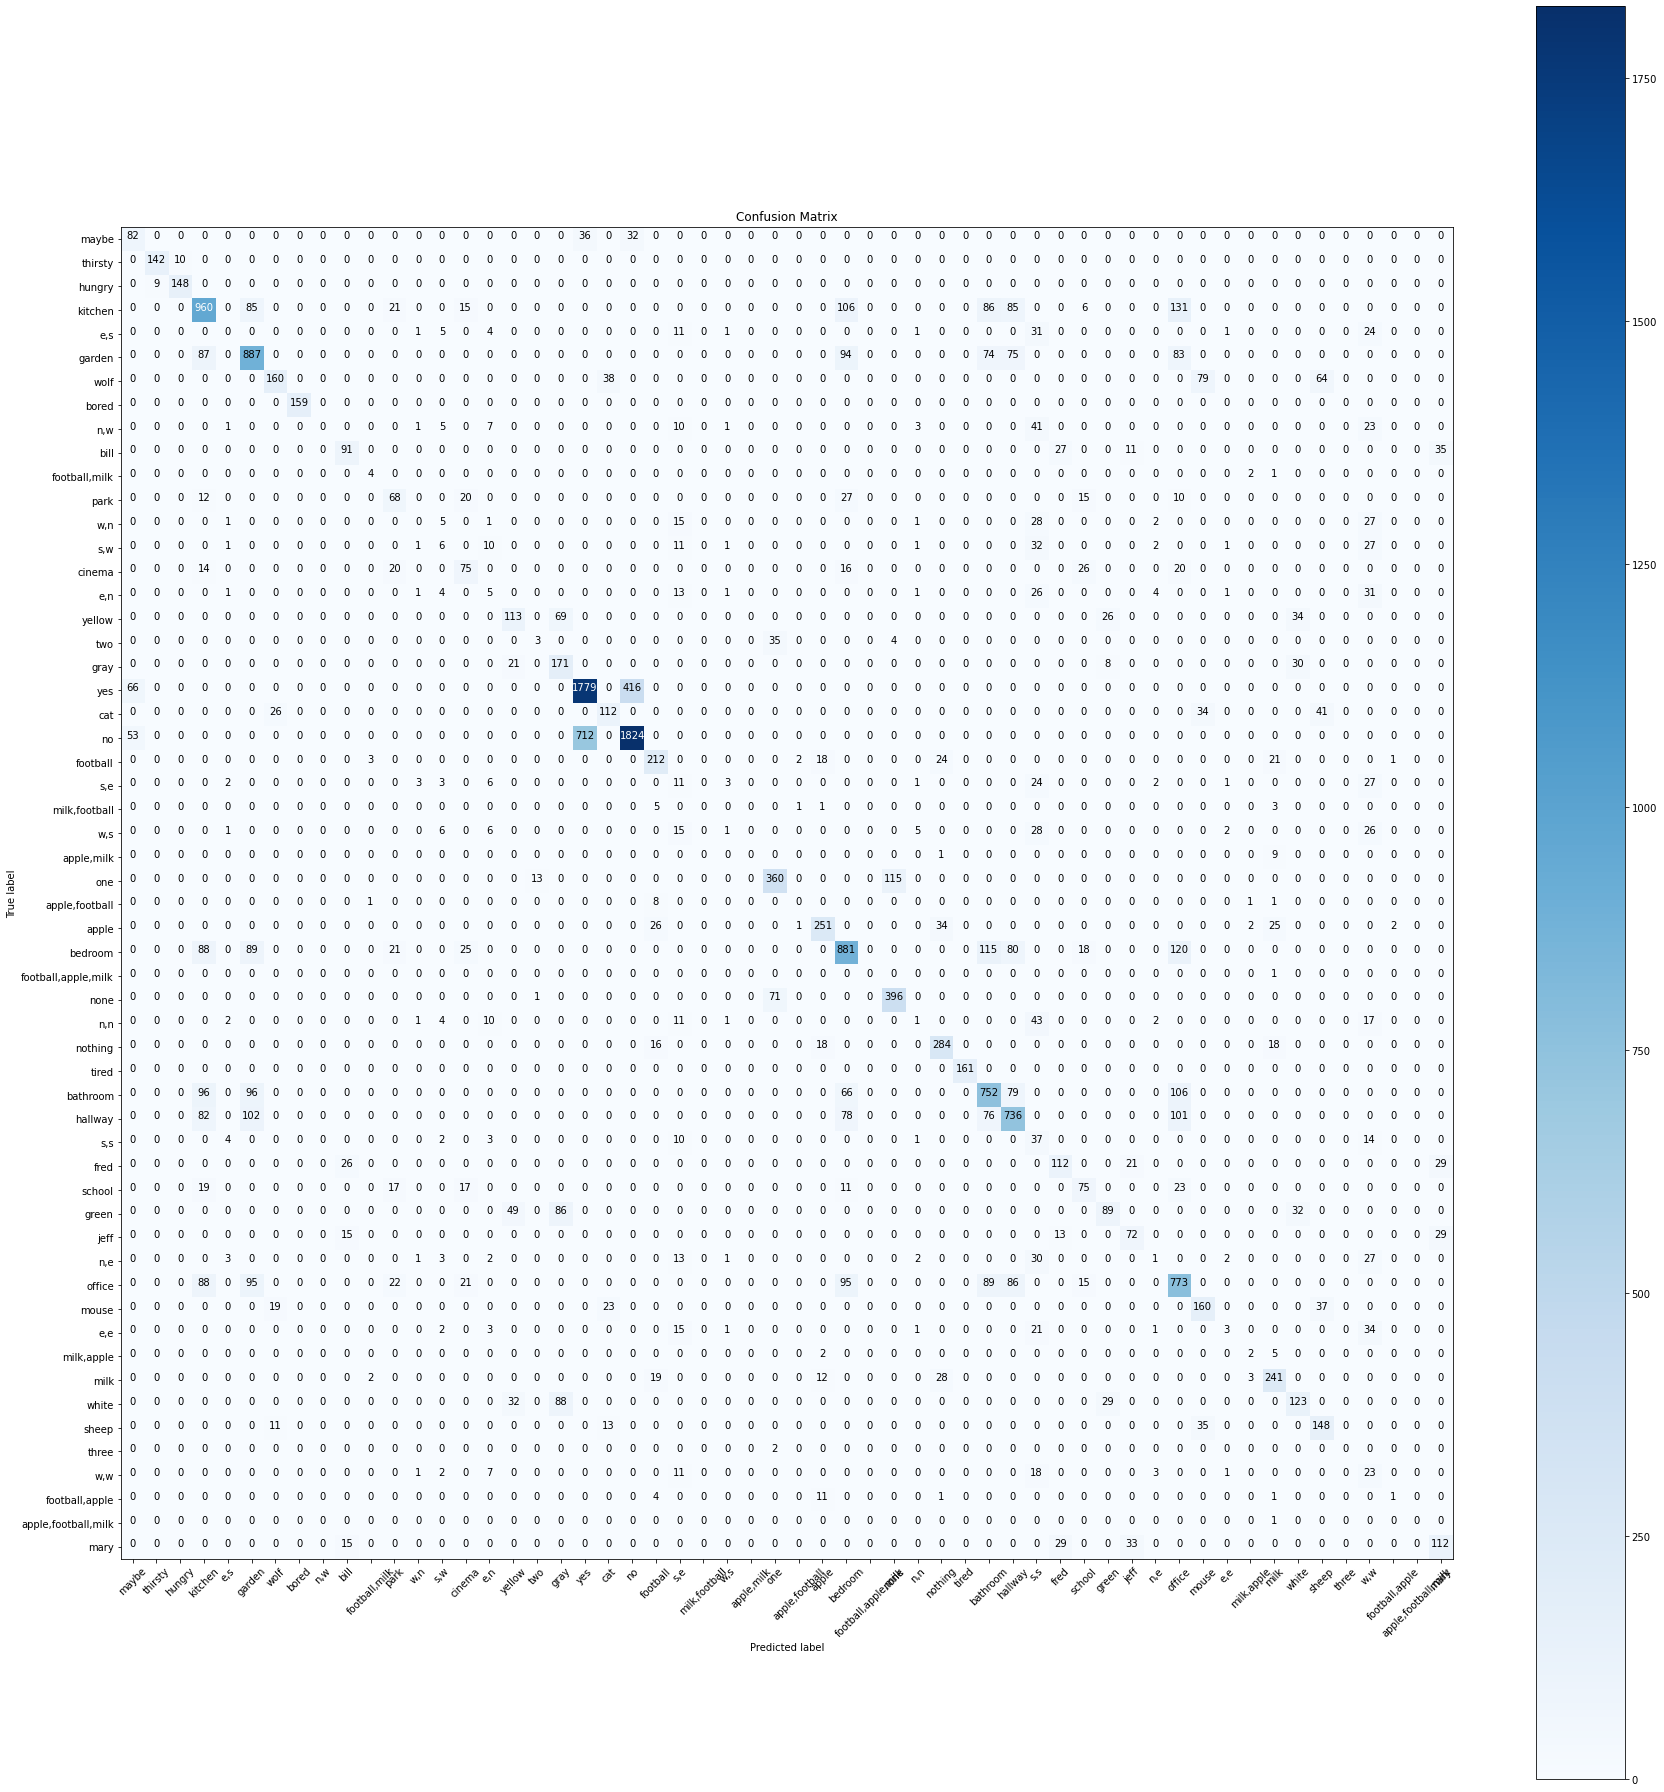

3.9162404537200928


In [5]:
batch_size=128
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
model.to(device)
checkpoint_name = f'checkpoints/{model_name}/best_checkpoint_26_08_2021__01_15_06.pt'# f'checkpoints/{model_name}/best_checkpoint_{now}.pt'
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
m = nn.Softmax(dim=1)

babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
                           vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
vocab_size = len(babi_dataset.QA.VOCAB)
print('len(babi_dataset) train', len(babi_dataset))
print('vocab_size', vocab_size)
babi_dataset.set_mode('test')
test_loader = DataLoader(
    babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
)

y_pred_extended = []
y_true_extended = []
y_pred_task = [[] for _ in range(20)]
y_true_task = [[] for _ in range(20)]

start = time.time()
with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(test_loader, desc=f"Inference")):
        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)

        logits = torch.squeeze(model(contexts, questions)).cpu()
        # We consider a task successfully passed if ≥ 95% accuracy is obtained.
        y_pred = m(logits)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred = [babi_dataset.QA.IVOCAB[int(i)] for i in y_pred]
        y_true = [babi_dataset.QA.IVOCAB[int(i)] for i in answers.cpu()]
        y_pred_extended.extend(y_pred)
        y_true_extended.extend(y_true)
        for i in range(len(y_pred)):
            y_pred_task[int(tasks[i]) - 1].append(y_pred[i])
            y_true_task[int(tasks[i]) - 1].append(y_true[i])
end = time.time()

        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

accuracy = accuracy_score(y_pred_extended, y_true_extended)
cr = classification_report(y_true_extended, y_pred_extended)
print(accuracy)
print(cr)
task_acc = []
passed_tasks = []
for i in range(20):
    task_acc.append(accuracy_score(y_pred_task[i], y_true_task[i]))
    passed_tasks.append(1 if task_acc[i] >= 0.95 else 0)
print(task_acc)
print('passed_tasks:', passed_tasks)
print('no. passed_tasks:', sum(passed_tasks))
labels = list(set(y_true_extended).intersection(set(y_true_extended)))
cnf_matrix = confusion_matrix(y_true_extended, y_pred_extended, labels)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels, title = ('Confusion Matrix'))
plt.show()
print(end-start)

In [5]:
# from thop import profile
# from thop import clever_format

# macs, params = profile(model, inputs=(
#                         torch.randint(1, size=(1, 910)).type(torch.LongTensor).to(device), 
#                         torch.randint(1, size=(1, 13)).type(torch.LongTensor).to(device)))  # , 
# #                         custom_ops={YourModule: count_your_model})

# macs, params = clever_format([macs, params], "%.3f")
# print(macs, params)

In [9]:
# model.layers.append(model.layers[1])
print(len(model.perceiver_io.layers))
print(model.perceiver_io.layers)

3
ModuleList(
  (0): ModuleList(
    (0): PreNorm(
      (fn): Attention(
        (to_q): Linear(in_features=16, out_features=32, bias=False)
        (to_kv): Linear(in_features=16, out_features=64, bias=False)
        (to_out): Linear(in_features=32, out_features=16, bias=True)
      )
      (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (norm_context): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
    (1): PreNorm(
      (fn): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=16, out_features=128, bias=True)
          (1): GEGLU()
          (2): Linear(in_features=64, out_features=16, bias=True)
        )
      )
      (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
    (2): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (to_q): Linear(in_features=16, out_features=256, bias=False)
            (to_kv): Linear(in_features=16, out_features=512, bias=False)
       

In [10]:
print(babi_dataset.QA.VOCAB)

{'<PAD>': 0, '<EOS>': 1, 'mary': 2, 'moved': 3, 'to': 4, 'the': 5, 'bathroom': 6, '.': 7, 'john': 8, 'went': 9, 'hallway': 10, 'where': 11, 'is': 12, 'daniel': 13, 'back': 14, 'sandra': 15, 'garden': 16, 'office': 17, 'journeyed': 18, 'travelled': 19, 'bedroom': 20, 'kitchen': 21, 'got': 22, 'football': 23, 'there': 24, 'dropped': 25, 'milk': 26, 'took': 27, 'picked': 28, 'up': 29, 'apple': 30, 'left': 31, 'grabbed': 32, 'discarded': 33, 'put': 34, 'down': 35, 'was': 36, 'before': 37, 'north': 38, 'of': 39, 'south': 40, 'what': 41, 'west': 42, 'east': 43, 'bill': 44, 'gave': 45, 'fred': 46, 'did': 47, 'give': 48, 'handed': 49, 'jeff': 50, 'who': 51, 'received': 52, 'passed': 53, 'in': 54, 'no': 55, 'yes': 56, 'how': 57, 'many': 58, 'objects': 59, 'carrying': 60, 'one': 61, 'none': 62, 'two': 63, 'three': 64, 'nothing': 65, 'football,apple': 66, 'milk,apple': 67, 'apple,football': 68, 'football,milk': 69, 'milk,football': 70, 'milk,football,apple': 71, 'apple,milk': 72, 'apple,milk,foot